In [1]:
%matplotlib inline

In [2]:
!pip install rawpy

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import io, requests, rawpy

In [4]:
response = requests.get("https://github.com/moizumi99/raw_process/raw/master/sample.ARW")
raw = rawpy.imread(io.BytesIO(response.content))

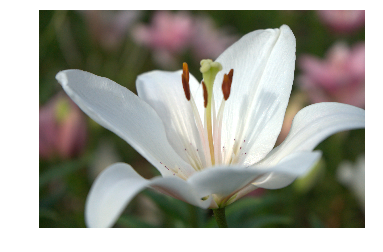

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
img_preview = raw.postprocess(use_camera_wb=True)
imshow(img_preview)
plt.axis('off')
plt.show()

In [6]:
print(raw.sizes)

ImageSizes(raw_height=4024, raw_width=6048, height=4024, width=6024, top_margin=0, left_margin=0, iheight=4024, iwidth=6024, pixel_aspect=1.0, flip=0)


In [7]:
import numpy as np
h, w = raw.sizes.raw_height, raw.sizes.raw_width
raw_image = raw.raw_image.copy()
raw_array = np.array(raw_image).reshape((h, w)).astype('float')

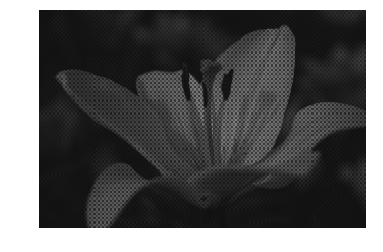

In [8]:
outimg = raw_array.copy()
outimg = outimg.reshape((h, w))
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg, cmap='gray')
plt.axis('off')
plt.show()

In [9]:
import imageio
raw_array_out = raw_array.copy()
raw_array_out = raw_array_out / raw_array_out.max() * 255
imageio.imwrite("raw_out.png", raw_array_out.astype('uint8'))

In [10]:
print(raw_array.min(), raw_array.max())

0.0 8180.0


In [11]:
blc = raw.black_level_per_channel
print(blc)

[512, 512, 512, 512]


In [12]:
bayer_pattern = raw.raw_pattern
print(bayer_pattern)

[[0 1]
 [1 2]]


In [ ]:
print(raw_array.min(), raw_array.max())
blc_raw = raw_array.copy()
for y in range(0, h, 2):
    for x in range(0, w, 2):
        blc_raw[y + 0, x + 0] -= blc[bayer_pattern[0, 0]]
        blc_raw[y + 0, x + 1] -= blc[bayer_pattern[0, 1]]
        blc_raw[y + 1, x + 0] -= blc[bayer_pattern[1, 0]]
        blc_raw[y + 1, x + 1] -= blc[bayer_pattern[1, 1]]
print(blc_raw.min(), blc_raw.max())

0.0 8180.0


In [ ]:
outimg = blc_raw.copy()
outimg = outimg.reshape((h, w))
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
dms_img = np.zeros((h//2, w//2, 3))

In [ ]:
for y in range(0, h, 2):
    for x in range(0, w, 2):
        colors = [0, 0, 0, 0]
        colors[bayer_pattern[0, 0]] += blc_raw[y + 0, x + 0]
        colors[bayer_pattern[0, 1]] += blc_raw[y + 0, x + 1]
        colors[bayer_pattern[1, 0]] += blc_raw[y + 1, x + 0]
        colors[bayer_pattern[1, 1]] += blc_raw[y + 1, x + 1]
        dms_img[y // 2, x // 2, 0] = colors[0]
        dms_img[y // 2, x // 2, 1] = (colors[1] + colors[3])/ 2
        dms_img[y // 2, x // 2, 2] = colors[2]

In [ ]:
outimg = dms_img.copy()
outimg = outimg.reshape((h // 2, w //2, 3))
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg)
plt.axis('off')
plt.show()

In [ ]:
wb = np.array(raw.camera_whitebalance)
print(wb)

In [ ]:
img_wb = dms_img.copy().flatten().reshape((-1, 3))
for index, pixel in enumerate(img_wb):
    pixel = pixel * wb[:3] /max(wb)
    img_wb[index] = pixel

In [ ]:
outimg = img_wb.copy().reshape((h // 2, w //2, 3))
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg)
plt.axis('off')
plt.show()

In [ ]:
print(raw.color_matrix)

In [ ]:
color_matrix = np.array([[1141, -205, 88], [-52, 1229, -154], [70, -225, 1179]]) / 1024

In [ ]:
img_ccm = np.zeros_like(img_wb)
for index, pixel in enumerate(img_wb):
    pixel = np.dot(color_matrix, pixel)
    img_ccm[index] = pixel

In [ ]:
outimg = img_ccm.copy().reshape((h // 2, w //2, 3))
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg)
plt.axis('off')
plt.show()

In [ ]:
import math

img_gamma = img_ccm.copy().flatten()
img_gamma[img_gamma < 0] = 0
img_gamma = img_gamma/img_gamma.max()
for index, val in enumerate(img_gamma):
    img_gamma[index] = math.pow(val, 1/2.2)
img_gamma = img_gamma.reshape((h//2, w//2, 3))

In [ ]:
outimg = img_gamma.copy().reshape((h // 2, w //2, 3))
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg)
plt.axis('off')
plt.show()

In [ ]:
import imageio

outimg = img_gamma.copy().reshape((h // 2, w //2, 3))
outimg[outimg < 0] = 0
outimg = outimg * 255
imshow(outimg.astype('uint8'))
plt.axis('off')
plt.show()

imageio.imwrite("sample.png", outimg.astype('uint8'))